In [1]:
# Some data-handling functions to download/import.

# from https://github.com/yandexdataschool/mlhep2018/blob/master/day2-Tue/seminar-03-keras-cnn/seminar_tf_keras.ipynb
"""I load some cifar"""

import numpy as np
from sklearn.model_selection import train_test_split
import os, sys
if sys.version_info[0] == 2:
    from urllib import urlretrieve
    import cPickle as pickle

else:
    from urllib.request import urlretrieve
    import pickle

def unpickle(file):
    fo = open(file, 'rb')
    if sys.version_info[0] == 2:
        dict = pickle.load(fo)
    else:
        dict = pickle.load(fo,encoding='latin1')

    fo.close()
    return dict




def download_cifar10(path,
                     url='https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz',
                     tarname='cifar-10-python.tar.gz',):
    import tarfile
    if not os.path.exists(path):
        os.mkdir(path)



    urlretrieve(url, os.path.join(path,tarname))
    tfile = tarfile.open(os.path.join(path,tarname))
    tfile.extractall(path=path)


def load_cifar10(data_path=".",channels_last=False,test_size=0.2,random_state=1337):

    test_path = os.path.join(data_path,"cifar-10-batches-py/test_batch")
    train_paths = [os.path.join(data_path,"cifar-10-batches-py/data_batch_%i"%i) for i in range(1,6)]

    if not os.path.exists(test_path) or not all(list(map(os.path.exists, train_paths))):
        print ("Dataset not found. Downloading...")
        download_cifar10(data_path)

    train_batches = list(map(unpickle,train_paths))
    test_batch = unpickle(test_path)

    X = np.concatenate([batch["data"] for batch in train_batches]).reshape([-1,3,32,32]).astype('float32')/255
    y = np.concatenate([batch["labels"] for batch in train_batches]).astype('int32')
    X_train,X_val,y_train,y_val = train_test_split(X,y,
                                                   test_size=test_size,
                                                   random_state=random_state)

    X_test = test_batch["data"].reshape([-1,3,32,32]).astype('float32')/255
    y_test = np.array(test_batch["labels"]).astype('int32')

    if channels_last:
        #convert from [batch,3,H,W] to [batch,H,W,3]
        #WARNING! Make this is only necessary for tensorflow-style dim order
        #If you use theano-style dimensions in keras config, skip this cell
        X_train = X_train.transpose([0,2,3,1])
        X_val   = X_val.transpose([0,2,3,1])
        X_test  = X_test.transpose([0,2,3,1])


    return X_train,y_train,X_val,y_val,X_test,y_test

In [2]:
import tensorflow as tf
#gpu_options = tf.GPUOptions(allow_growth=True, per_process_gpu_memory_fraction=0.1) # restricts GPU load for multi-user nodes

import tensorflow.keras as keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.18.0
3.8.0


In [3]:
# Load the data samples

x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer",
                   "dog", "frog", "horse", "ship", "truck"]

print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)
print("Val samples:", x_val.shape, y_val.shape)

Dataset not found. Downloading...
Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)
Val samples: (10000, 32, 32, 3) (10000,)


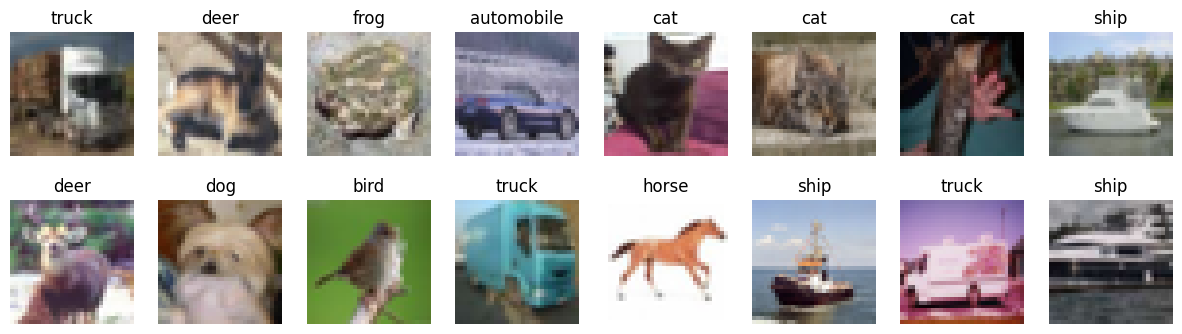

In [4]:
# show some random images from train, and their labels

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

In [5]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# x_train = x_train.astype(np.float64) - 0.5

y_train = keras.utils.to_categorical(y_train, num_classes=10)

y_val = keras.utils.to_categorical(y_val, num_classes=10)

y_test = keras.utils.to_categorical(y_test, num_classes=10)

print(y_train.shape, y_val.shape, y_test.shape)

(40000, 10) (10000, 10) (10000, 10)


In [6]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Activation, LeakyReLU




---


**Introduction**



---



The difference to before is that the images are more complex, but also contain more information: colour. The complexity requires neural networks like CNNs, which use more layers in the model. In general, GPUs would be great - not so great that I lost access to it midway...



---



**Model Strategy**



---



*   ***Conv2D:***

I define several CNN to extract the features of the from the earlier layers (first one extracts them from the image). Smaller filter sizes are more apt in detecting simpler features, bigger filters on the other hand are greater for finding broader, more complex characteristics. The 4 main convolutional layers therefore increase with 32 -> 64 -> 128 -> 256.

Smaller kernel sizes make sure that finer details can be observed. (3,3) works well here since the image size is quite small.

Non-linearity is added to the layers through the activation functions. I chose an abbreviated version of ReLu, which also allows slightly negative values (score is the better word maybe), meaning that potentially "dead neurons" (https://ai.stackexchange.com/questions/40576/why-use-relu-over-leaky-relu) can be avoided, depending on the alpha value chosen. That being said, it's only a minor adjustment, since the model doesn't seem to be prone to these problems.

Padding="same" just implies that output and input dimensions are the same.

*   ***BatchNormalization***

Essentially does what also has been done to the initial datasets: the inputs are normalized. It seems to me that it worked quite well with high learning rates, keeping the accuracy increase.

*   ***MaxPooling2D***

The pooling layer is applied for each new CNN layer in the model. The parameters are reduced, but since we also increase the number neurons for the CNNs, we can still stick to an efficient training. On the other hand, the decrease of spatial resolution means that we can train on more global patterns (again, this is so that the early layers focus on simple features, the latter layers on more complex ones).

*   ***Yielding the weight matrix***

Finally, for the output, the input is reduced to a 1D array again using Flatten(). We again create a neural network to learn from the data, then extrapolate the findings to our 10 classes.

*   ***Layers I initially planned to implement***

Tried to use Dropout(). However, it appeared the model couln't properly process the information, as it plateaued at quite an early stage. Even smaller increments simply worsened the performance.

Initially wanted to use (3,3) pool size, I thought that would speed up the process. In the end, that measure simply lead to slow incline.

Planned to add Gaussian Noise... well that was before the gpu failed, so I'm not sure how much that would have helped.

---



In [7]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """

    model = Sequential()

    ### STUDENT CODE HERE ###

    # CNN Layer 1
    model.add(Conv2D(32, (3,3), padding="same", input_shape=(32, 32, 3)))
    model.add(LeakyReLU(alpha=0.05))  # Alpha controls how much negative values are kept
    model.add(BatchNormalization())  # Training should be stabilized
    model.add(MaxPooling2D(pool_size=(2,2)))  # Reduces dimensions

    # CNN Layer 2
    model.add(Conv2D(64, (3,3), padding="same"))
    model.add(LeakyReLU(alpha=0.05))  # Alpha controls how much negative values are kept
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CNN Layer 3
    model.add(Conv2D(128, (3,3), padding="same"))
    model.add(LeakyReLU(alpha=0.05))  # Alpha controls how much negative values are kept
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    # CNN Layer 4
    model.add(Conv2D(256, (3,3), padding="same"))
    model.add(LeakyReLU(alpha=0.05))  # Alpha controls how much negative values are kept
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))

    ## Extracting the findings

    # Flattening
    model.add(Flatten())

    # Building a fully connected network of the findings
    model.add(Dense(128, activation="relu"))

    # Saving the "feedback" for each of the classes.
    model.add(Dense(10, activation="softmax"))


    ### END STUDENT CODE ###

    return model

In [ ]:
from keras.optimizers import SGD
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.preprocessing.image import ImageDataGenerator



---

**Fitting strategy**

---

My strategy was to save as much time as possible, while not loosing on accuracy (as that would be the case with strides). I originally also generated new, distorted data for the model to work on, but well, that was time consuming. Another idea was to first fit the model to the original data and when a certain accuracy was reached, use a self-defined callback to fit the current model to the generated data. That made the model to plateau at 68%.

The main achievement of the fit is the implementation of callbacks and decaying learning rates.

---

**Choice of Parameters**

---

I used a high learning rate in the beginning, then gradually decreased it for more precision. The high learning rate worked well in conjunction with the model's BatchNormalization layers, allowing for the accuracy to rapidly increase. As for the decreasing learning rate, I wanted to prevent overfitting. Additionally, this allowed for more fine-tuning at later epochs.

The batch size was honestly simply chosen due to how well it worked with the fit. The result was a quicker code. It might have been an idea to change the batch size after a certain amount of epoch, to get the final generalizing touch.



---

***Functions***

---



*   *Optimizer*

For the optimizer, I initially used Adam, but later replaced it with SGD. That way, higher accuracies could be reached. From what I've read, the advantage is also avoiding potential overfitting. I also found it more interesting, especially regarding the functioning of the moving average (momentum argument). Same goes for nesterov=True.

The decay rate was chosen to quickly push the learning rate into a normal region, since the initial rapid increase in accuracy only held on for a few epochs. If I get the chance to run the code again with a GPU, the decay rate might need to be reduced / there should be a minimum value at which the learning rate would stay constant.  

*   ***Callbacks***

I included several callbacks that made sure the progress went into the direction of increasing accuracy.

To avoid unnecessary long runtimes, the fit is stopped with EarlyStopping: This looks for val_loss improvements in the previous [patience] epochs, finishes and saves the best fit if the val_loss didn't improved in that time.

ModelCheckpoint saves a model if it is better than the previous one. If for some epoch, the fit causes a reduce in accuracy, it is removed from "memory" and fit continues with the previous model.

Lastly, ReduceLROnPlateau detects whether the fit is currently plateauing and highly decreases the learning rate. That way, it might be possible to escape the plateau.



---




In [9]:
### STUDENT CODE HERE ###
### --> change the parameters below to perform a better training

INIT_LR = 1e-3  # initial learning rate
BATCH_SIZE = 128
EPOCHS = 50 # might seem like much, but progress will be stopped if plateaued


### Planned to include generated images, but was too time consuming.
datagen = ImageDataGenerator(zoom_range=[0.8,1.2],
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

### Now the actual code begins

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

optimizer = SGD(learning_rate=INIT_LR, momentum=0.9, decay=1e-3, nesterov=True)

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer= optimizer,  # for SGD.
    metrics=['accuracy']  # report accuracy during training
)


## Define the callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True) # patience might be adjusted for quicker changes

model_checkpoint = ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_loss", verbose=1
)

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, verbose=1)

## Fit model
history = model.fit(
    x_train, y_train,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(x_val, y_val),
    shuffle=True,
    callbacks=[early_stopping, lr_scheduler, model_checkpoint]
)

# save weights to file to avoid re-training
model.save_weights("myweights.weights.h5")

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 512ms/step - accuracy: 0.3595 - loss: 2.0965
Epoch 1: val_loss improved from inf to 2.14068, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 172s 540ms/step - accuracy: 0.3597 - loss: 2.0963 - val_accuracy: 0.3053 - val_loss: 2.1407 - learning_rate: 0.0100
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 500ms/step - accuracy: 0.5788 - loss: 1.8840
Epoch 2: val_loss improved from 2.14068 to 1.93566, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 200s 534ms/step - accuracy: 0.5788 - loss: 1.8840 - val_accuracy: 0.5242 - val_loss: 1.9357 - learning_rate: 0.0100
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 513ms/step - accuracy: 0.6624 - loss: 1.8026
Epoch 3: val_loss improved from 1.93566 to 1.88875, saving model to best_model.keras
313/313 ━━━━━━━━━━━━━━━━━━━━ 203s 539ms/step - accuracy: 0.6624 - loss: 1.8026 - val_accuracy: 0.5708 - val_loss: 1.8888 - learning_rate: 0.0100
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 510ms/s

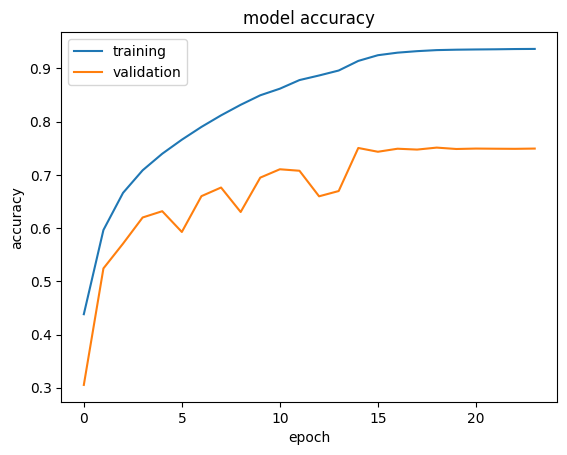

In [10]:
## Simple copy of the accuracy plots from the MNIST exercise: Plot the progression of the training accuracy

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [24]:
# load weights from file (can call without model.fit)
model.load_weights("myweights.weights.h5")

In [ ]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 38ms/step


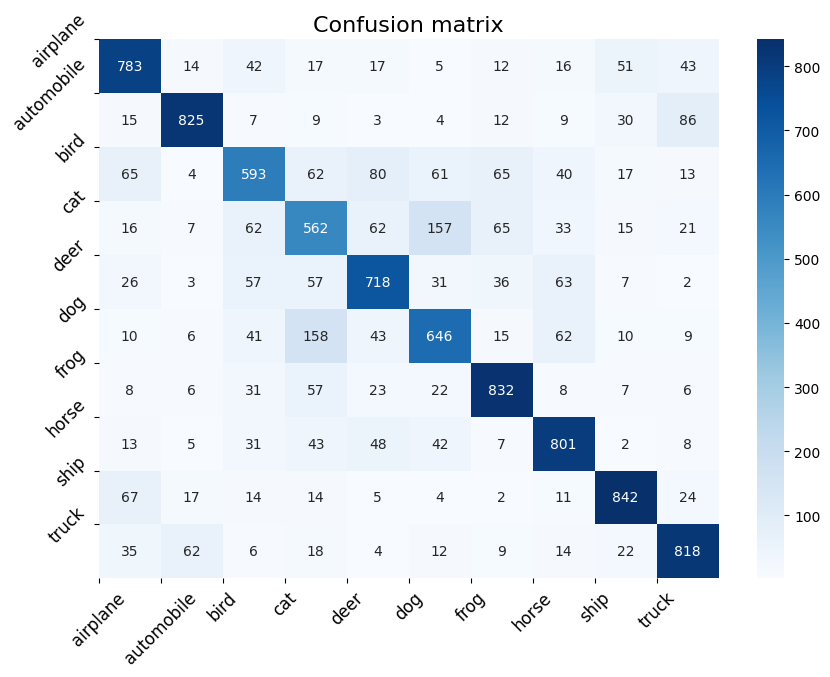

Test accuracy: 0.742


In [33]:
# make test predictions
y_pred_test = model.predict(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)
y_test_index = [list(onehot).index(1) for onehot in y_test]

## Plot a heatmap of the confusion matrix results
plt.figure(figsize=(10, 7))
sns.heatmap(confusion_matrix(y_test_index, y_pred_test_classes), annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion matrix', fontsize=16)
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.show()
print("Test accuracy:", accuracy_score(y_test_index, y_pred_test_classes))

In [15]:

from sklearn.metrics import classification_report

print(classification_report(y_test_index, y_pred_test_classes, target_names=cifar10_classes))


              precision    recall  f1-score   support

    airplane       0.75      0.78      0.77      1000
  automobile       0.87      0.82      0.85      1000
        bird       0.67      0.59      0.63      1000
         cat       0.56      0.56      0.56      1000
        deer       0.72      0.72      0.72      1000
         dog       0.66      0.65      0.65      1000
        frog       0.79      0.83      0.81      1000
       horse       0.76      0.80      0.78      1000
        ship       0.84      0.84      0.84      1000
       truck       0.79      0.82      0.81      1000

    accuracy                           0.74     10000
   macro avg       0.74      0.74      0.74     10000
weighted avg       0.74      0.74      0.74     10000





---

**Comments**

---

Cats seem to be misidentified the most, closely followed by birds. When looking at the heat map, the algorithm cannot properly distinguish between cats and dogs. Birds, probably due to their variety and diversity of backgrounds, are often chosen instead of the actual class.



---



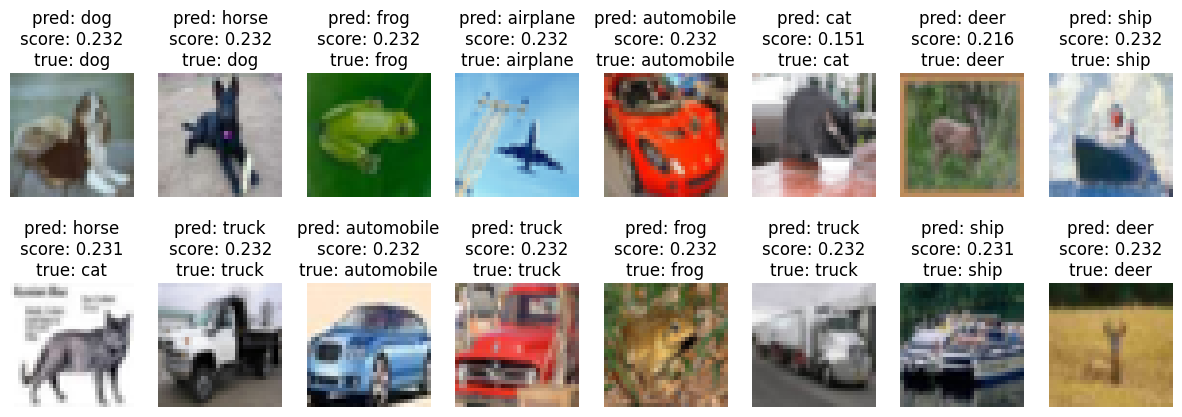

In [12]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test_index[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

*Note that the saliency map code is definitely written by ChatGPT, only minor adjustments. Simply wanted to use this as a method for analysis.*

In [18]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def compute_saliency_map(model, image, label_index):
    """
    Computes a saliency map for the given image and model.

    Parameters:
        model: Trained Keras model
        image: Single input image of shape (32, 32, 3)
        label_index: Target class index (integer)

    Returns:
        saliency_map: A heatmap of pixel importance
    """
    # Convert the image to a tensor and enable gradient tracking
    image = tf.convert_to_tensor(image[None, ...], dtype=tf.float32)  # Add batch dimension
    with tf.GradientTape() as tape:
        tape.watch(image)  # Track gradients w.r.t. image pixels
        predictions = model(image)  # Forward pass
        class_score = predictions[:, label_index]  # Extract target class score

    # Compute gradients w.r.t the input image
    gradients = tape.gradient(class_score, image)

    # Take absolute values (positive = important pixels)
    saliency_map = tf.abs(gradients)
    saliency_map = tf.reduce_max(saliency_map, axis=-1)  # Max over color channels

    return saliency_map.numpy().squeeze()  # Remove batch dimension


In [21]:
def plot_saliency(image, saliency_map,):
    """
    Plots the original image and its saliency map.
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Original Image
    ax[0].imshow(image)
    ax[0].set_title("Original Image")


    # Saliency Map (heatmap)
    ax[1].imshow(saliency_map, cmap="hot", alpha=0.8)
    ax[1].set_title("Saliency Map")


    plt.show()




---

**Analysis of Saliency Map**

---

*(put here since output is too long)*

What can quickly be seen when reviewing the maps is that the algorithm seems to be doing good at identifying the position of the class inside the image. The cat, ship or other main characters of the images always contribute the most to the fit.

However, major issues aris due to the way that the algorithm favors certain parts of the labelled character. As an example, the most distinguishing feature of cats is their facial structure. The model seems to focus more on the body, not the shape of the cat. The cat is therefore misidentified as a frog.

Often times, the classes are also identified by their surroundings. This is especially true for planes, and it explains why there is such a big mismatch between planes and birds.

The similar shape (or maybe similar type of unnatural shape) of vehicles also makes sense. Trucks, ships and planes are often unnaturally stretched in one direction, and the algorithm appears to (unfortunately) pick up on that.



---



pred: ship
score: 0.232
true: ship


<Figure size 1500x500 with 0 Axes>

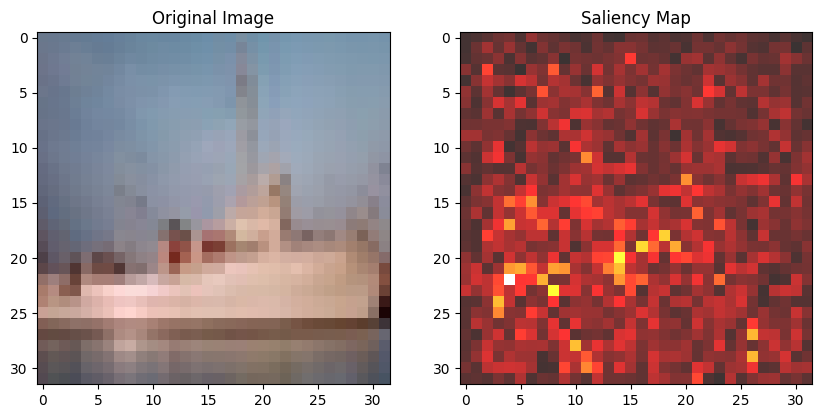

pred: automobile
score: 0.176
true: automobile


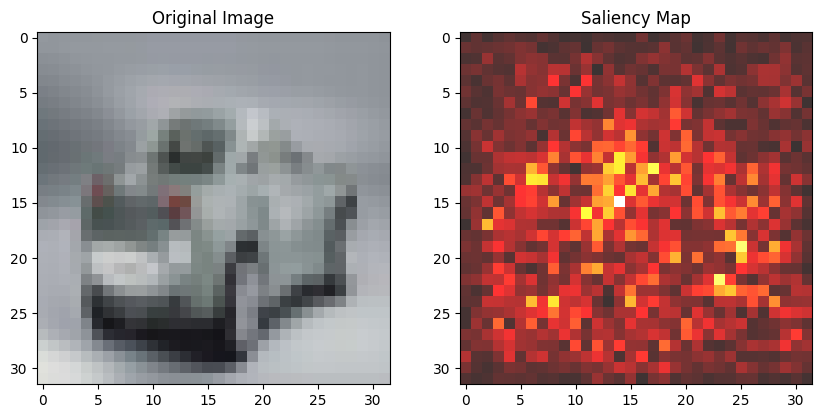

pred: airplane
score: 0.227
true: airplane


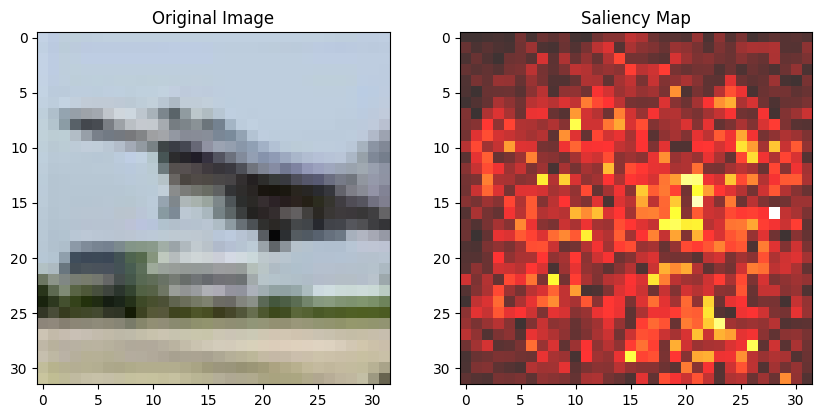

pred: airplane
score: 0.229
true: truck


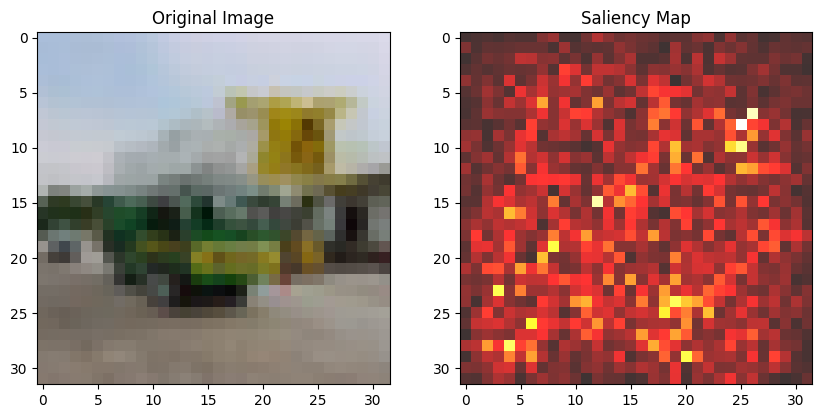

pred: ship
score: 0.232
true: ship


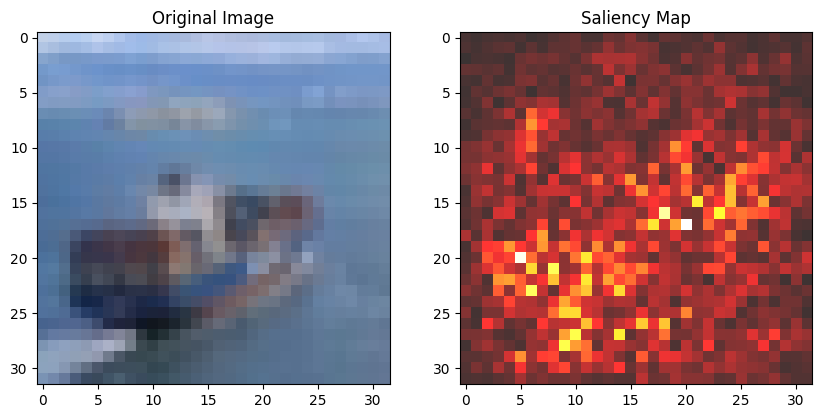

pred: horse
score: 0.232
true: horse


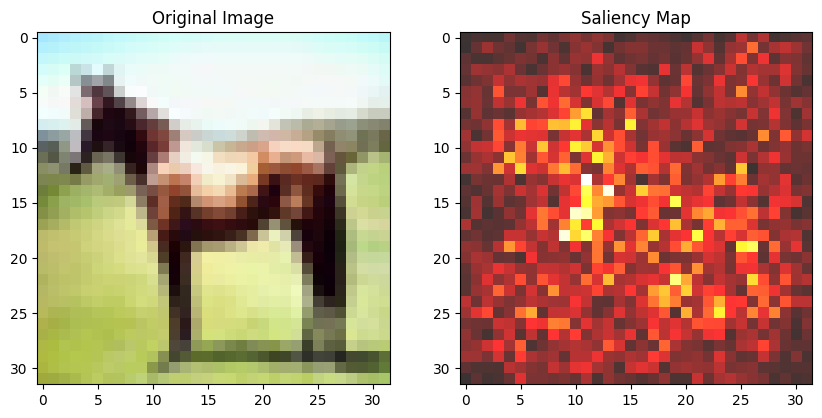

pred: frog
score: 0.223
true: deer


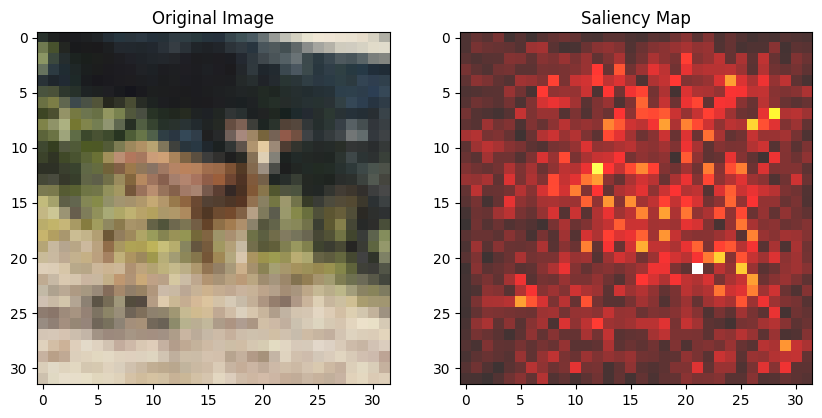

pred: deer
score: 0.232
true: deer


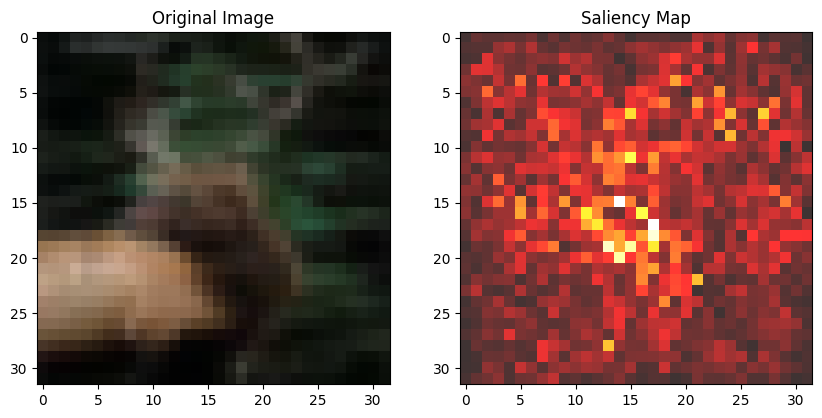

pred: frog
score: 0.229
true: cat


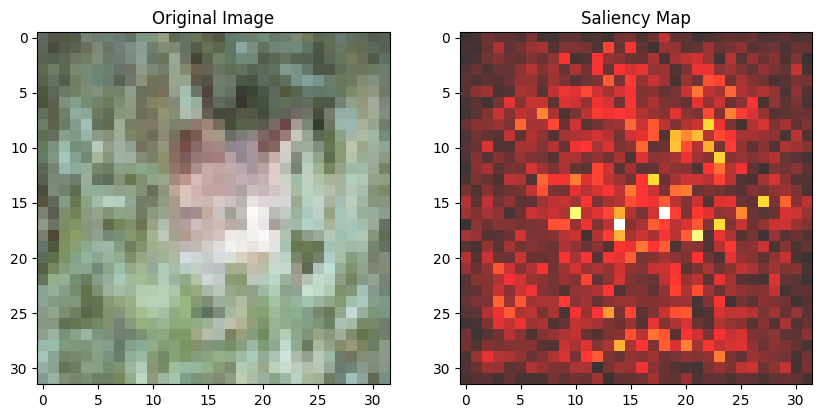

pred: ship
score: 0.232
true: ship


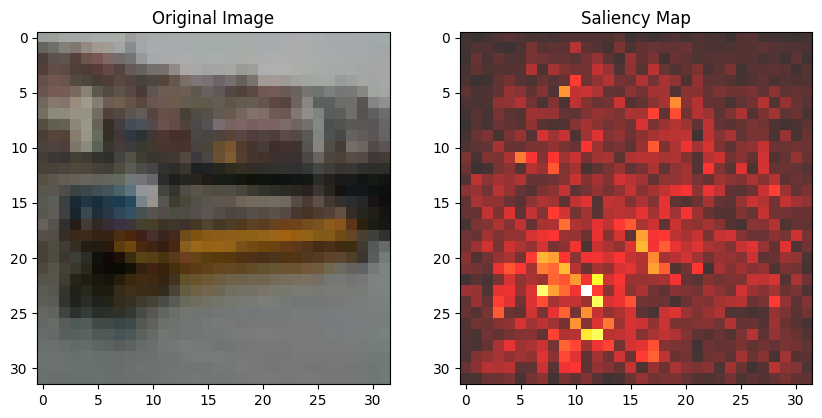

pred: automobile
score: 0.232
true: bird


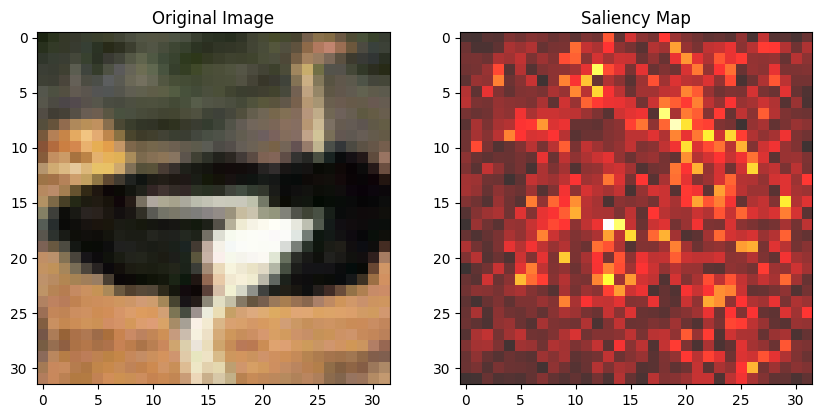

pred: ship
score: 0.232
true: ship


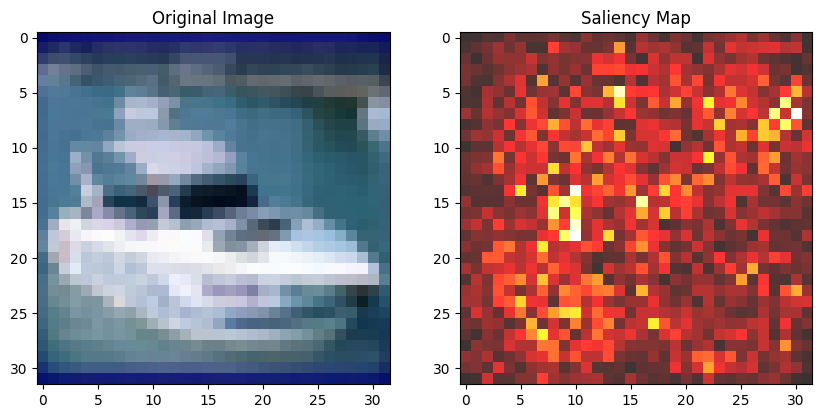

pred: truck
score: 0.232
true: truck


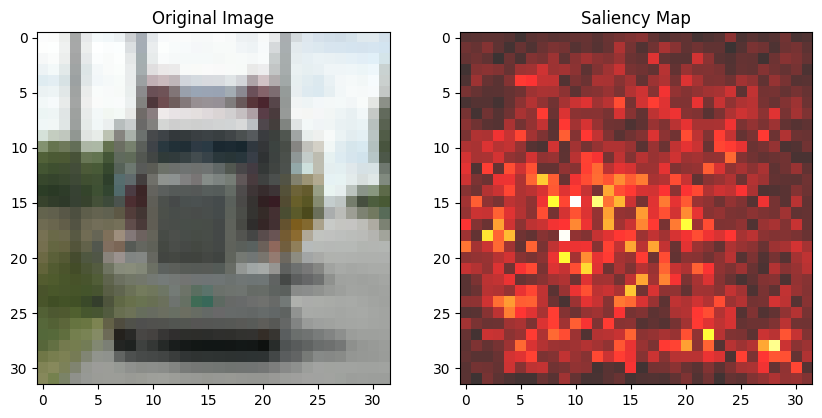

pred: bird
score: 0.15
true: horse


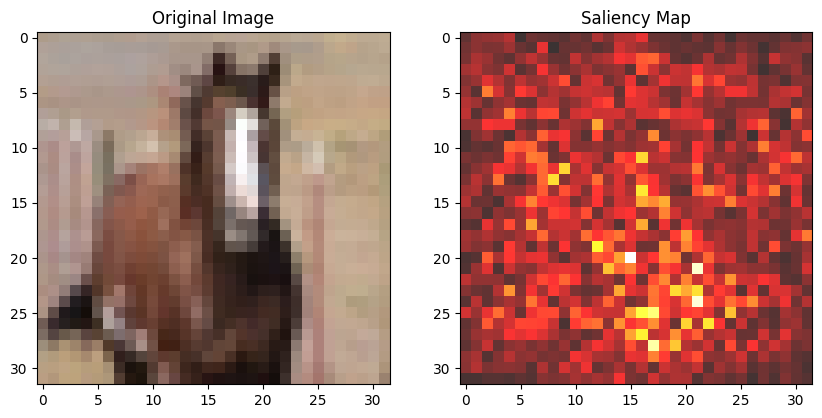

pred: truck
score: 0.232
true: truck


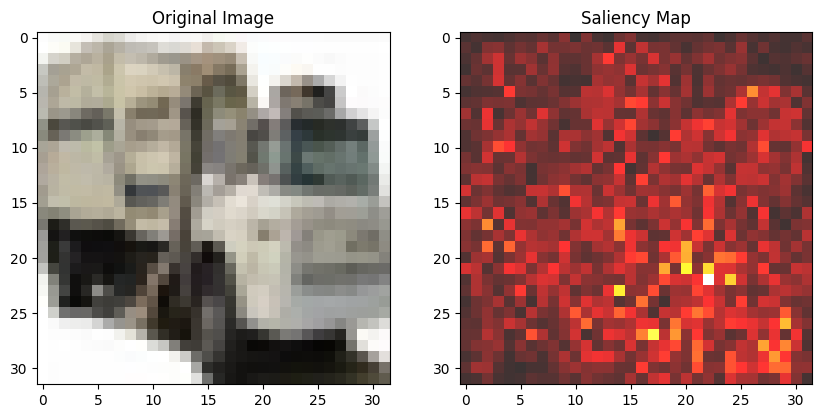

pred: horse
score: 0.232
true: horse


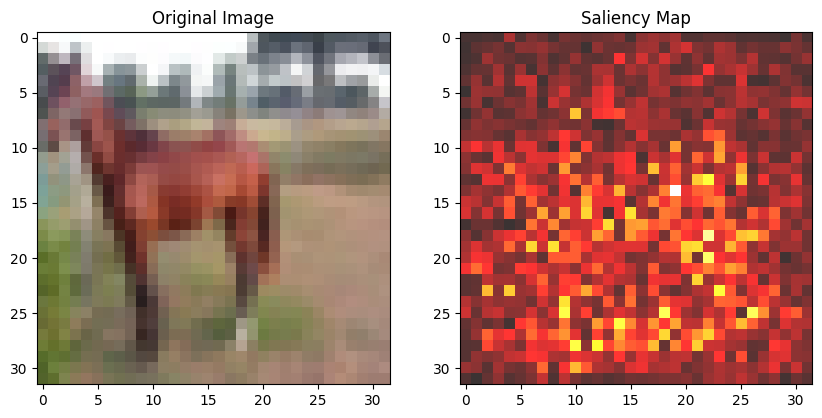

pred: ship
score: 0.232
true: ship


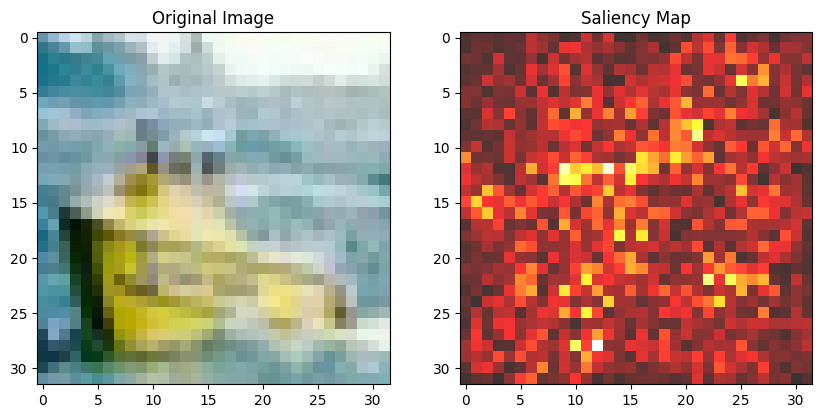

pred: ship
score: 0.232
true: ship


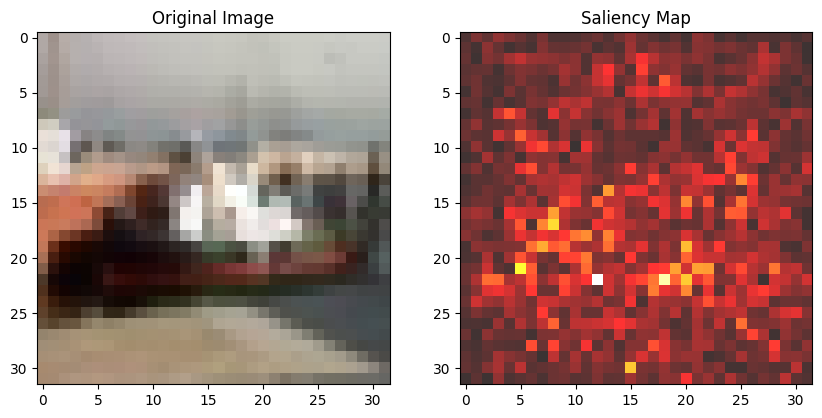

pred: frog
score: 0.232
true: bird


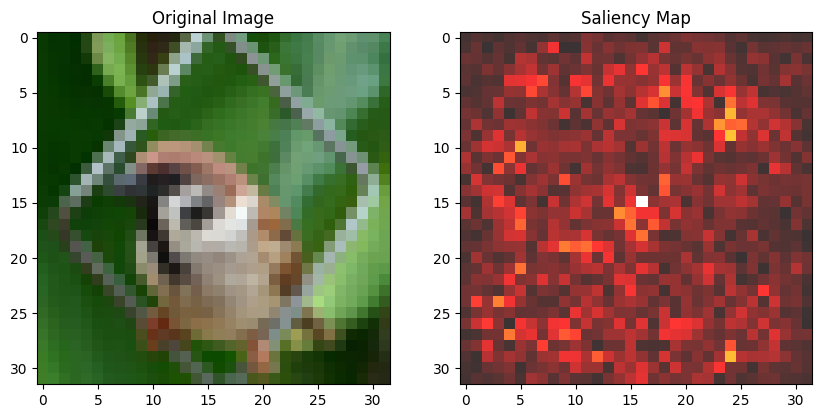

pred: airplane
score: 0.225
true: airplane


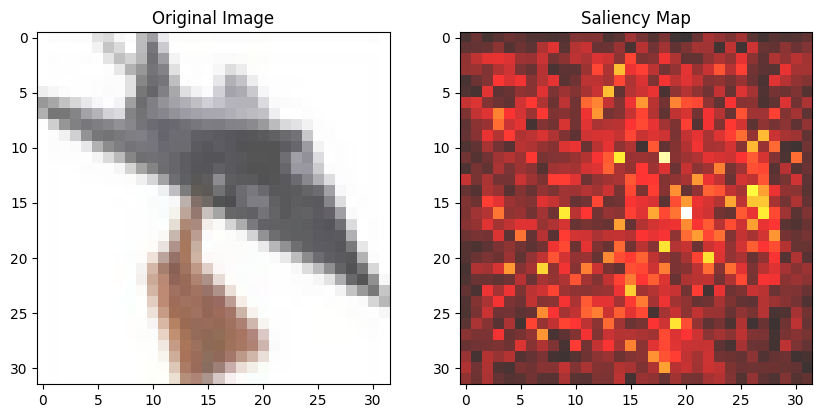

pred: dog
score: 0.232
true: dog


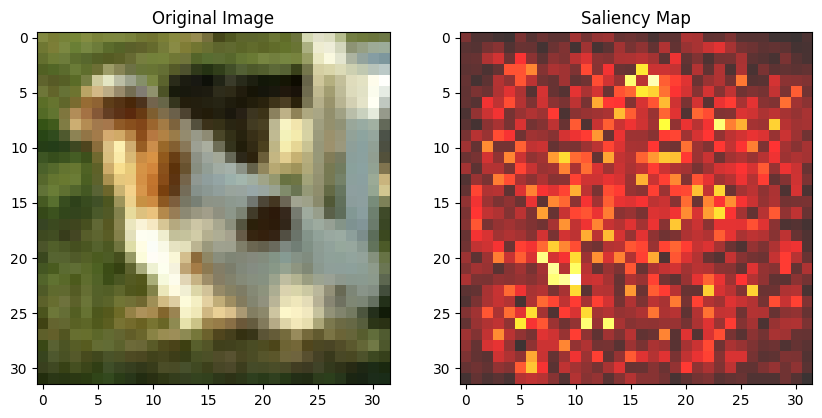

pred: automobile
score: 0.231
true: automobile


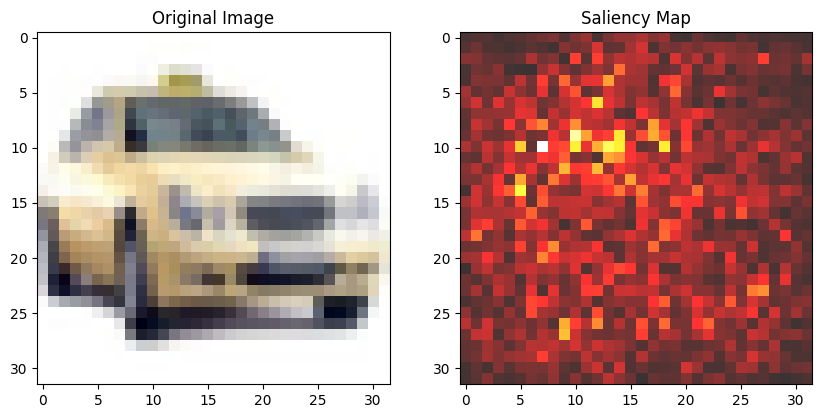

pred: cat
score: 0.231
true: cat


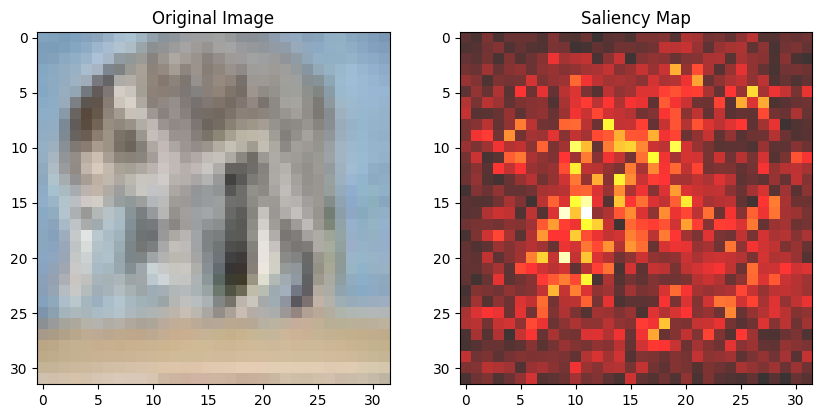

pred: ship
score: 0.232
true: ship


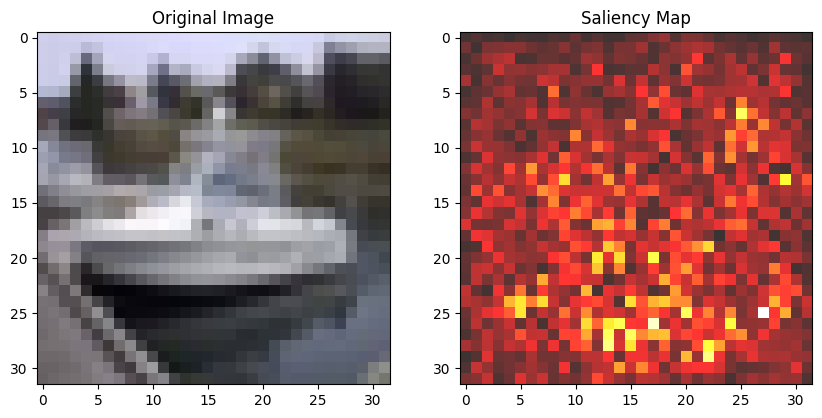

pred: airplane
score: 0.232
true: airplane


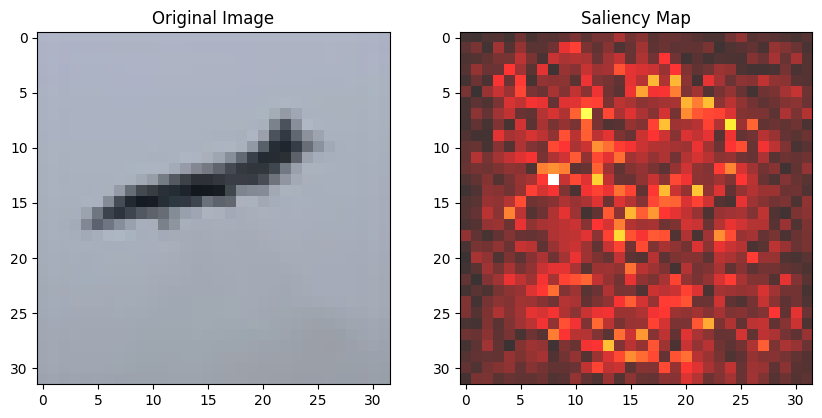

pred: airplane
score: 0.232
true: airplane


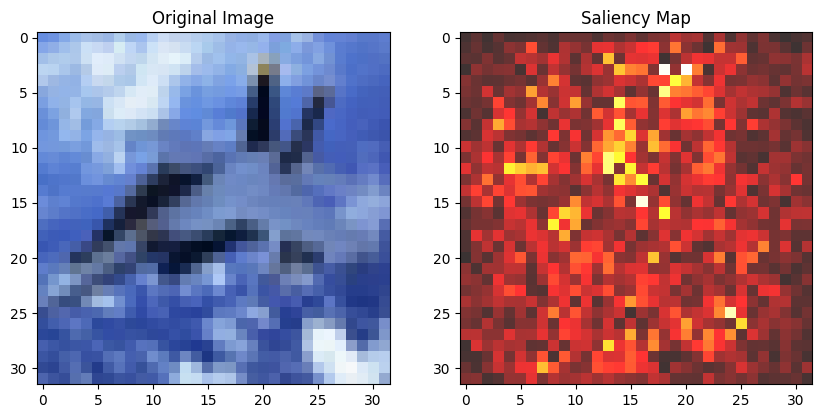

pred: bird
score: 0.23
true: bird


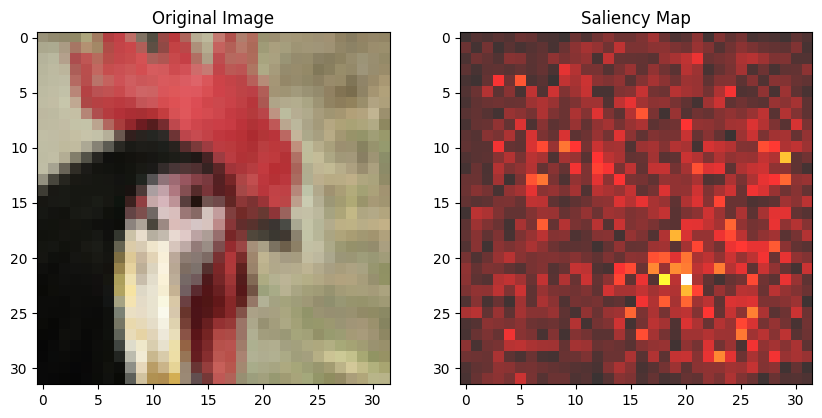

pred: ship
score: 0.232
true: airplane


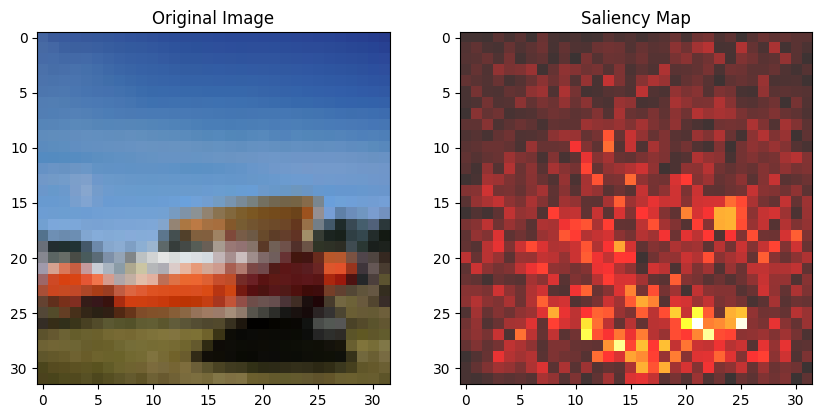

pred: deer
score: 0.232
true: deer


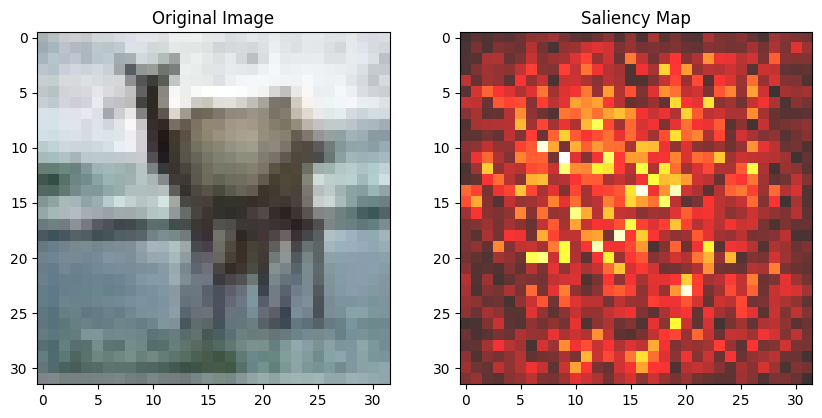

pred: airplane
score: 0.232
true: airplane


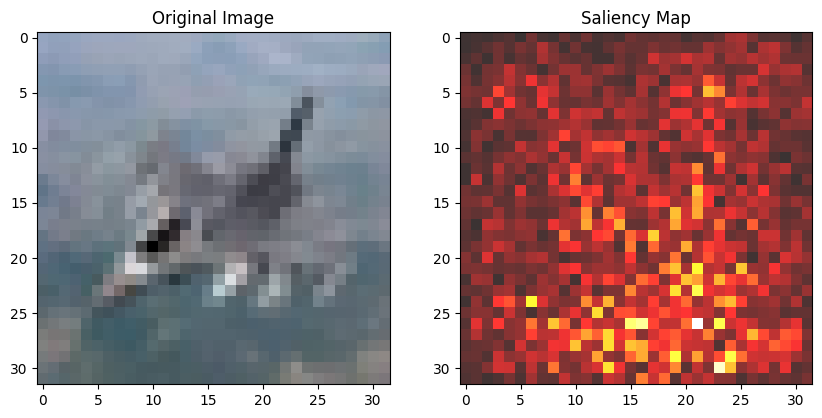

pred: bird
score: 0.231
true: bird


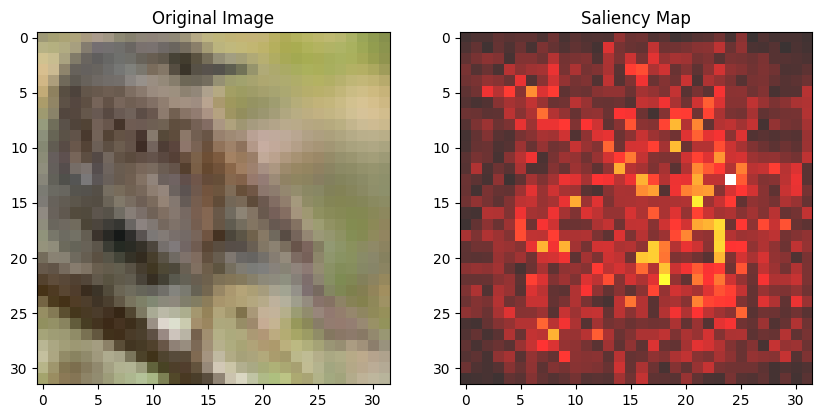

pred: airplane
score: 0.232
true: airplane


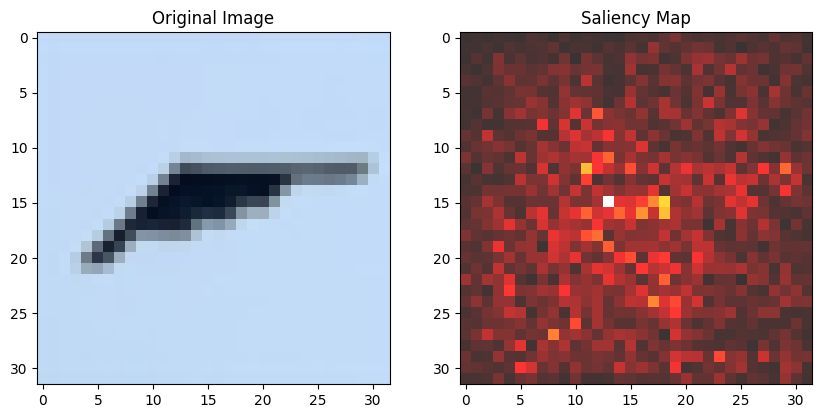

pred: deer
score: 0.232
true: deer


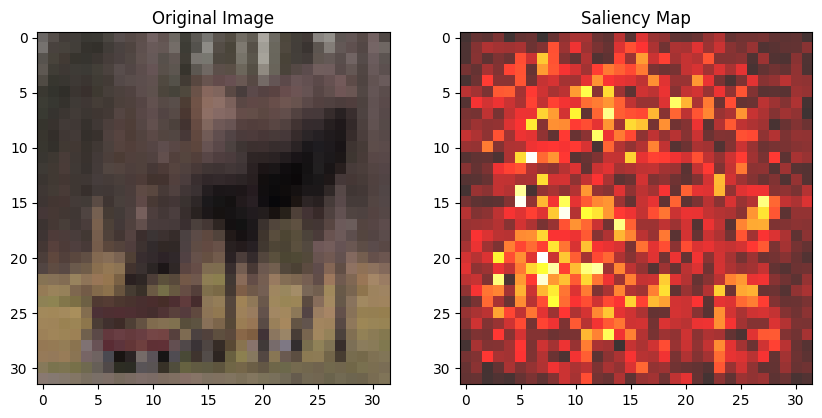

pred: horse
score: 0.232
true: horse


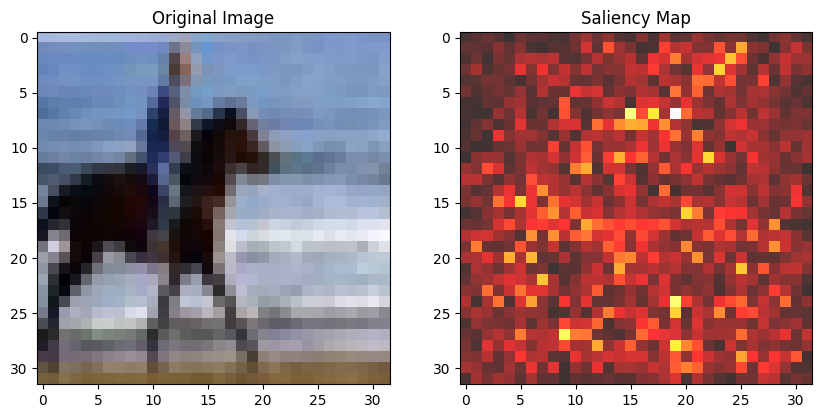

pred: frog
score: 0.178
true: cat


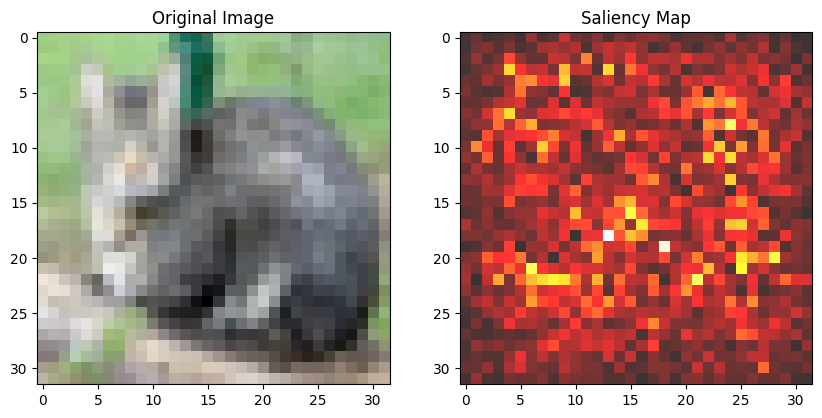

pred: horse
score: 0.232
true: horse


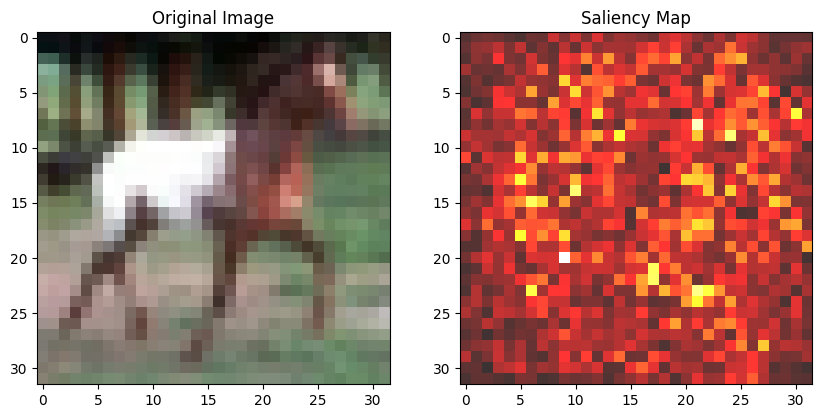

pred: truck
score: 0.232
true: truck


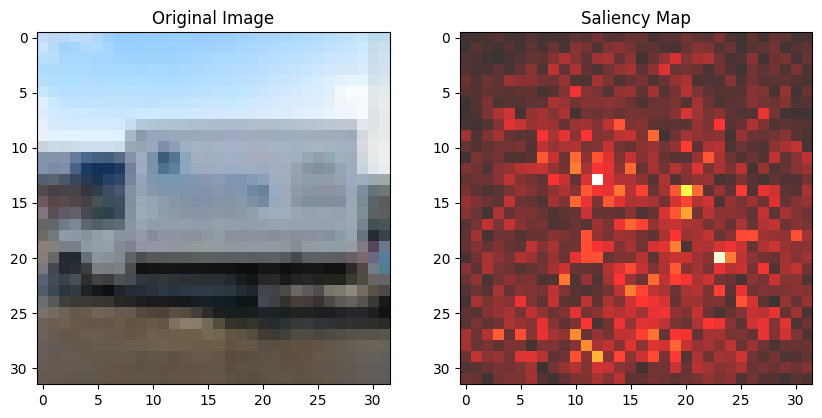

pred: truck
score: 0.232
true: truck


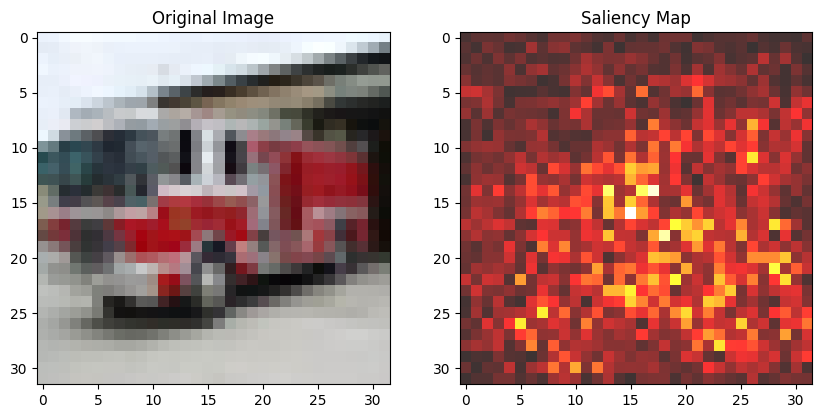

pred: horse
score: 0.172
true: horse


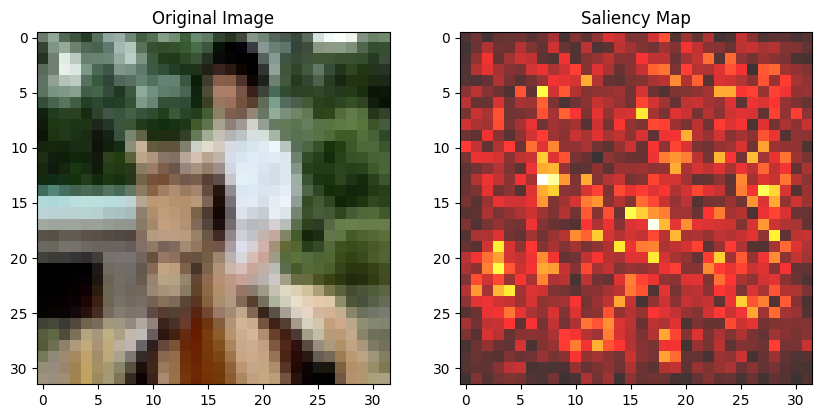

pred: airplane
score: 0.232
true: airplane


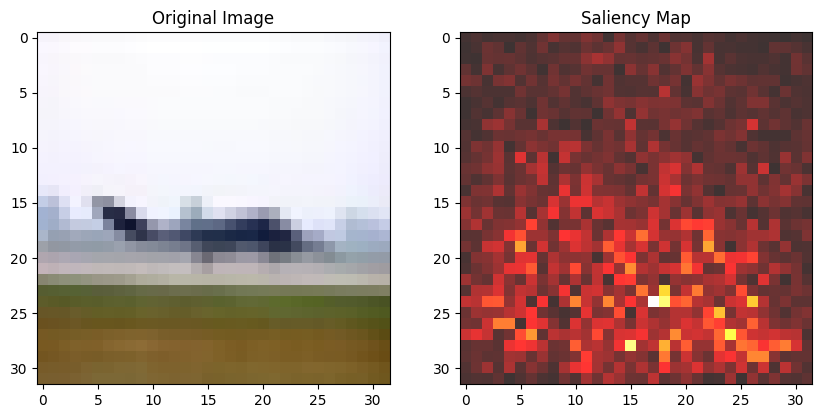

In [32]:
# Select a test image and its true label
index = 40  # Pick a sample size


fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for j in range(index):
    random_index = np.random.randint(0, len(y_test))
    image = x_test[random_index]  # Extract image
    true_label_1 = y_test_index[random_index]  # Get true label index

    # Compute Saliency Map
    saliency = compute_saliency_map(model, image, true_label_1)


    # Plot Saliency Map

    pred_label = cifar10_classes[y_pred_test_classes[random_index]]
    pred_proba = y_pred_test_max_probas[random_index]
    true_label = cifar10_classes[y_test_index[random_index]]

    print("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
    plot_saliency(image, saliency)

# Some tips on how to improve:

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.

## Potential grading:
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)

## Bonus points
Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example \"A super-small/fast NN that gets 80%\" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)


## Tips on what can be done:

 * __Network size__
   * More neurons,
   * More layers, ([lasagne docs](http://lasagne.readthedocs.org))
   * Nonlinearities in the hidden layers
   * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
     `                       num_filters = n_neurons,`
     `                       filter_size = (filter width, filter height),`
     `                       nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.

   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc


 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum


 * __Faster optimization__ -
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better


 * __Data augmentation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image):
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.


